<a href="https://colab.research.google.com/github/araujoheloysa/DIO_BairesDev_Machine-Learning-Practitioner/blob/main/Redes_Neurais_com_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing libraries**

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.image as mpimg
import random

# **2. Dataset cats and dogs**

In [ ]:
# Dataset URL
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# Download the dataset
data_cats_dogs_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=False)

# Extract the zip file manually
with zipfile.ZipFile(data_cats_dogs_zip, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(data_cats_dogs_zip)) # Extract to the same directory as the zip file

# Define the path to the extracted dataset
data_cats_dogs = os.path.join(os.path.dirname(data_cats_dogs_zip), 'cats_and_dogs_filtered') # Path to the extracted 'PetImages' folder

# **3. Separate the dataset into train and validation**

In [ ]:
# 70% dataset for training
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_cats_dogs,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(160, 160),
  batch_size=32)

# 30% dataset for validation
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_cats_dogs,
  validation_split=0.30,
  subset="validation",
  seed=123,
  image_size=(160,160),
  batch_size=32)


Found 3000 files belonging to 2 classes.
Using 2100 files for training.
Found 3000 files belonging to 2 classes.
Using 900 files for validation.


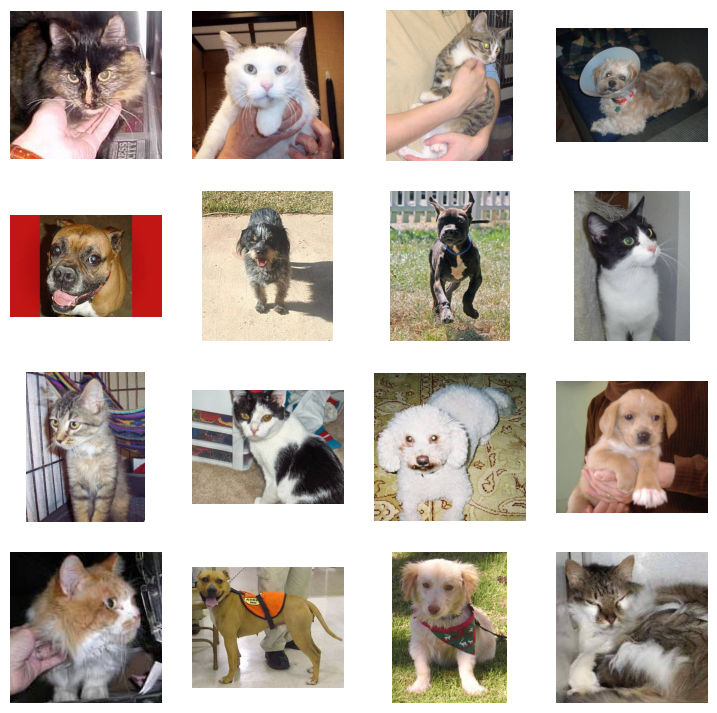

In [ ]:
#Checking the files
cat_dir = os.path.join(data_cats_dogs, 'train', 'cats')
dog_dir = os.path.join(data_cats_dogs, 'train', 'dogs')

# Selects all available images
cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir)]
dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir)]

# Randomly select 8 images from each
random_cat_pix = random.sample(cat_files, 8)
random_dog_pix = random.sample(dog_files, 8)

# Combined list of images
all_images = random_cat_pix + random_dog_pix
random.shuffle(all_images)

# Iterates over the list of images and displays each one
fig, axes = plt.subplots(4, 4, figsize=(9, 9))
axes = axes.flatten()

for ax, img_path in zip(axes, all_images):
    ax.axis('off')
    img = mpimg.imread(img_path)
    ax.imshow(img)

plt.show()


# **4. Loading the Pre-trained Model**

In [ ]:
# Loads the pre-trained MobileNet model, excluding the last two layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

In [ ]:
# Adds a global pooling layer to reduce dimensionality
x = GlobalAveragePooling2D()(base_model.output)

# Adds intermediate layer with L2 regularization
x = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_dir = os.path.join(data_cats_dogs, 'train')
validation_data_dir = os.path.join(data_cats_dogs, 'validation')

# Creating Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,  # Use the correct path
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

# Callbacks used during training to improve the model and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Frozen layers to train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

# Unfreezes the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Compile again at a lower learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Fine-Tuning
history_finetune = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7971 - loss: 1.2918 - val_accuracy: 0.9710 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9503 - loss: 0.7057 - val_accuracy: 0.9810 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9664 - loss: 0.4752 - val_accuracy: 0.9750 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9630 - loss: 0.3719 - val_accuracy: 0.9710 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9474 - loss: 0.3234 - val_accuracy: 0.9840 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9703 - loss: 0.2418 - val_accuracy: 0.9760 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9625 - loss: 0.2239 - val_accuracy: 0.9680 - v

In [ ]:
# Evaluation after fine-tuning
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation model accuracy after fine-tuning: {val_accuracy * 100:.2f}%")
print(f"Loss model after fine-tuning: {val_loss:.4f}")


In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()


plt.plot(history_finetune.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.title('Fine-tuning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()


# **5. Uploading a picture of a cat or dog to test the model**

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  img_path = fn
  img = image.load_img(img_path, target_size=(160, 160))
  img_array = image.img_to_array(img) / 255.0
  img_array = tf.expand_dims(img_array, axis=0)

  predictions = model.predict(img_array)

  predicted_class = 'Cachorro' if predictions[0][0] > 0.5 else 'Gato'

  print(f"A imagem é um: {predicted_class}")